 Importar dependencias
 

In [1]:
# Librerías base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Conexión Mongo
from dotenv import load_dotenv
from pymongo import MongoClient

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA             # <-- IMPORTAR PCA




In [2]:
import os
load_dotenv()
MONGO_URI = os.getenv("CONECTION_DB")

if MONGO_URI:
    print("✅ URI cargada correctamente")
else:
    print("❌ No se encontró la URI")


✅ URI cargada correctamente


Helper para exportar Mongo a CSV

In [3]:
import os

def export_mongo_sample_to_csv(
    db_name: str,
    collection_name: str,
    out_csv: str = "dataset_sample.csv",
    sample_size: int = 100000,
    projection: dict | None = None,
):
    # Si ya existe el archivo, lo leemos directo
    if os.path.exists(out_csv):
        print(f"⚠️ El archivo {out_csv} ya existe, cargando en memoria...")
        df = pd.read_csv(out_csv)
        print(f"✅ Cargados {len(df)} registros desde CSV existente")
        return df

    # Si no existe, conectamos a Mongo y generamos muestra
    mongo_uri = os.getenv("CONECTION_DB")
    client = MongoClient(mongo_uri)
    col = client[db_name][collection_name]

    pipeline = [{"$sample": {"size": sample_size}}]
    if projection:
        pipeline.append({"$project": projection})

    cursor = col.aggregate(pipeline)
    data = list(cursor)

    df = pd.json_normalize(data)
    df.to_csv(out_csv, index=False)
    client.close()
    print(f"✅ Nueva muestra guardada en {out_csv} con {len(df)} registros")
    return df


In [4]:
df = export_mongo_sample_to_csv(
    db_name="luminarias",
    collection_name="luminarias",
    out_csv="dataset_sample.csv",
    sample_size=5000
)
df.head()


✅ Nueva muestra guardada en dataset_sample.csv con 5000 registros


,_id,identificador,tipo,potencia_watts,altura_metros,estado,createdAt,updatedAt,ubicacion.direccion,ubicacion.coordenadas.lat,...,mantenimiento.notas,mantenimiento.responsable,conectividad.estado_red,conectividad.latencia_ms,conectividad.firmware,eficiencia.lumens_por_watt,eficiencia.horas_funcionamiento_total,eficiencia.vida_util_restante_pct,registro.fecha_instalacion,registro.creado_por
0,685e05c1fc791db76e0685ae,yucmda01021610318129,Halógena,75,8.08,fallando,2025-06-27 02:45:22.916,2025-06-27 02:45:22.916,"54563 Hamilton Cliffs\nEast Chelsea, WA 50025",16.993697,...,Difficult guess level.,Maximiliano Zúñiga,estable,95.8,v2.0.1,98.15,9799,55.1,2024-02-01,admin_sistema
1,685e06bffc791db76e1f504f,verver05021595588914,LED,50,6.57,fallando,2025-06-27 02:49:38.287,2025-06-27 02:49:38.287,"2826 Ruiz Crest Apt. 299\nLake Amandaberg, TX ...",15.231270,...,Hit land yourself remain task game hour.,Gustavo Barrera,estable,98.5,v1.0.0,106.56,5514,74.1,2025-02-05,admin_sistema
2,685e0ae1fc791db76e5138fc,sincul1803179784043,LED,50,8.59,fallando,2025-06-27 03:07:18.790,2025-06-27 03:07:18.790,"501 Rachel Walk Suite 774\nSmithfort, NJ 11506",17.650813,...,Media affect after plant carry them suggest.,Tomás Rangel,inestable,89.9,v1.0.0,127.88,3363,38.9,2025-03-18,admin_sistema
3,685e0545fc791db76efbf4b0,méxnez02051495202718,Incandescente,50,9.88,apagada,2025-06-27 02:43:23.356,2025-06-27 02:43:23.356,"653 Tracey Run\nNew Anna, ND 11795",14.600890,...,Marriage game yeah computer piece kid group.,Leonardo Beltrán,inestable,41.7,v1.0.0,129.68,9127,51.7,2024-05-02,admin_sistema
4,685e0721fc791db76e272e54,tabvillah02062210674844,Incandescente,50,7.51,encendida,2025-06-27 02:51:17.781,2025-06-27 02:51:17.781,"39579 Susan Land\nMelanietown, CT 25295",22.471072,...,This travel action quickly able hand.,Ulises Mondragón,sin conexión,92.2,v2.0.1,117.48,7650,42.7,2024-06-02,admin_sistema


In [5]:

from sklearn.discriminant_analysis import StandardScaler

# ========================
# 2. Cargar CSV
# ========================

df = pd.read_csv("dataset_sample.csv")


# ========================
# 2.1 Limpieza de datos
# ========================

# Eliminar duplicados
df = df.drop_duplicates()

# Eliminar filas con valores nulos en las columnas relevantes
df = df.dropna(subset=[
    "potencia_watts","altura_metros","consumo.actual_watts",
    "consumo.acumulado_kwh.dia","consumo.acumulado_kwh.semana",
    "consumo.acumulado_kwh.mes","sensores.luminosidad_lux",
    "sensores.movimiento","sensores.temperatura_c","sensores.humedad_pct",
    "conectividad.latencia_ms","eficiencia.lumens_por_watt",
    "eficiencia.horas_funcionamiento_total","eficiencia.vida_util_restante_pct",
    "mantenimiento.estado_lampara"
])

# Filtrar outliers en potencia y vida útil
df = df[(df["potencia_watts"] > 0) & (df["potencia_watts"] < df["potencia_watts"].quantile(0.99))]
df = df[(df["eficiencia.vida_util_restante_pct"] >= 0) & (df["eficiencia.vida_util_restante_pct"] <= 100)]

print(f"✅ Registros después de limpieza: {len(df)}")


# ========================
# 3. Selección de features
# ========================
features = [
    "potencia_watts","altura_metros","consumo.actual_watts",
    "consumo.acumulado_kwh.dia","consumo.acumulado_kwh.semana",
    "consumo.acumulado_kwh.mes","sensores.luminosidad_lux",
    "sensores.movimiento","sensores.temperatura_c","sensores.humedad_pct",
    "conectividad.latencia_ms","eficiencia.lumens_por_watt",
    "eficiencia.horas_funcionamiento_total","eficiencia.vida_util_restante_pct"
]

X = df[features]
y = df["mantenimiento.estado_lampara"]

# ========================
# 4. Codificar etiquetas
# ========================
le = LabelEncoder()
y = le.fit_transform(y)

# ========================
# 5. Escalado
# ========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========================
# 6. Train/Test Split
# ========================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# ========================
# 7. Modelo
# ========================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ========================
# 8. Evaluación
# ========================
y_pred = model.predict(X_test)

print("Reporte de Clasificación:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))


✅ Registros después de limpieza: 3808
Reporte de Clasificación:
               precision    recall  f1-score   support

       bueno       0.34      0.39      0.36       380
        malo       0.34      0.32      0.33       396
     regular       0.32      0.29      0.30       367

    accuracy                           0.34      1143
   macro avg       0.33      0.33      0.33      1143
weighted avg       0.33      0.34      0.33      1143


Matriz de Confusión:
 [[150 127 103]
 [152 128 116]
 [141 121 105]]


# Graficos


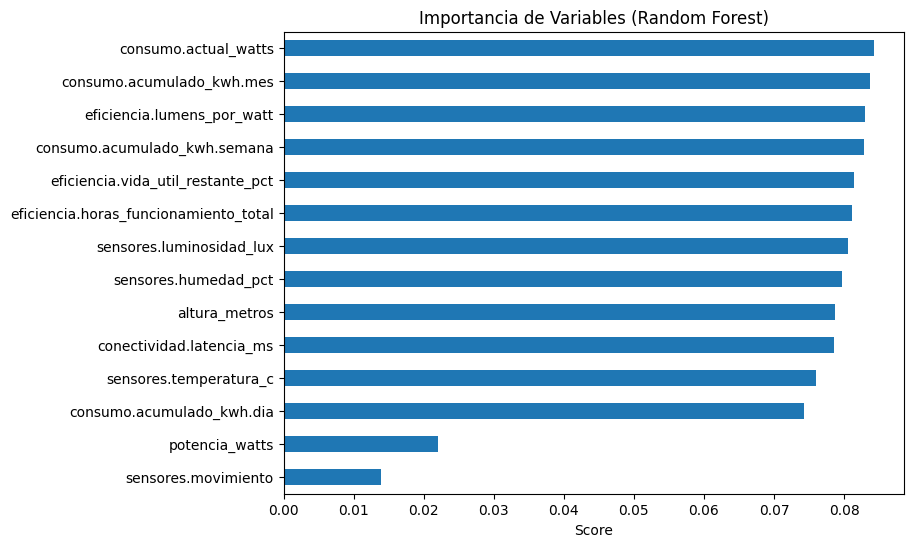

In [6]:
#1. Importancia de Variables

importances = model.feature_importances_
feat_importances = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8,6))
feat_importances.plot(kind='barh')
plt.title("Importancia de Variables (Random Forest)")
plt.xlabel("Score")
plt.show()


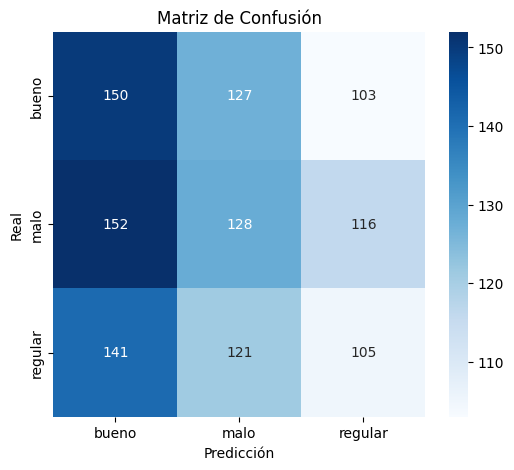

In [7]:
#2. Matriz de Confusión
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()


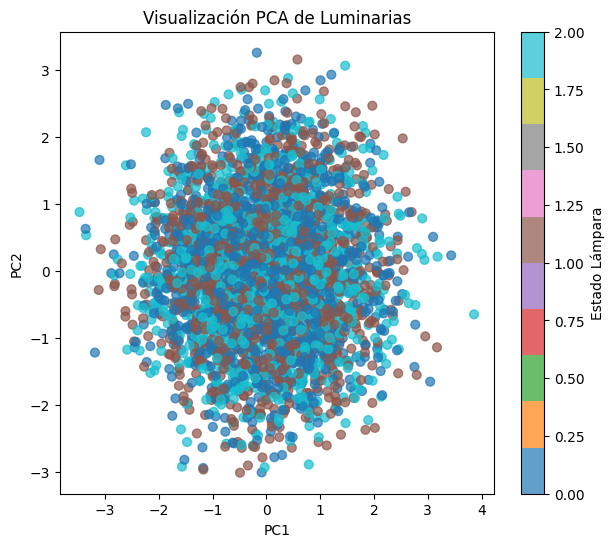

In [8]:
#3. Reducción de Dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=40, alpha=0.7)
plt.title("Visualización PCA de Luminarias")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Estado Lámpara")
plt.show()


In [9]:
# Agregar la predicción al DataFrame original
df["prediccion_estado"] = le.inverse_transform(model.predict(X_scaled))

# Filtrar por estado y guardar como JSON
df[df["prediccion_estado"] == "bueno"].to_json("luminarias_buenas.json", orient="records")
df[df["prediccion_estado"] == "regular"].to_json("luminarias_regulares.json", orient="records")
df[df["prediccion_estado"] == "malo"].to_json("luminarias_malas.json", orient="records")